In [1]:
import pandas as pd
import numpy as np
import glob
from scipy.stats import kendalltau

In [2]:
setC_exp_logP = {
    'Cn1cnc2c(N)ncnc21': 0.8,
    'Cn1ccc(N)nc1=O': 3.0,
    'Cn1ccc(=O)[nH]c1=O': 1.2,
    'Cc1cn(C)c(=O)[nH]c1=O': 0.5,
    'Cn1cnc2c(=O)[nH]c(N)nc21': 3.5,
    'Cc1c[nH]c2ccccc12': -2.2,
    'Cc1ccccc1': -2.3
}

setA_rmse = []
setA_tau = []
setB_rmse = []
setB_tau = []
setC_rmse = []

for csv_name in ['prediction_results_teacher.csv', 'prediction_results_student.csv'] + \
                sorted(glob.glob("prediction_results_student?.csv")) + \
                sorted(glob.glob("prediction_results_student??.csv")) + \
                sorted(glob.glob("prediction_results_control_student?.csv")) + \
                sorted(glob.glob("prediction_results_control_student??.csv")):

#for csv_name in ['prediction_results_student14.csv']:
    logP_exp = pd.read_csv('setA+setB_exp_values.csv')
    acidic_basic_pka = {}
    acidic_or_basic_solutes = logP_exp[~logP_exp.pKa.isna()]
    for solute in acidic_or_basic_solutes.can_smiles_solute.unique():
        pka = acidic_or_basic_solutes[acidic_or_basic_solutes.can_smiles_solute == solute].pKa.iloc[0]
        acidic_basic_pka[solute] = pka    
    ########################
    dgsolv_in_water = {}
    df = pd.read_csv(csv_name)
    df_setC = df[df.comment.str.contains('setC')]
    df = df[df.comment.str.contains('logP')]

    for _, row in df[df.can_smiles_solvent == 'O'].iterrows():
        dgsolv_in_water[row['can_smiles_solute']] = row['predicted']
    ##################
    logP_pred = []
    for _, row in logP_exp.iterrows():
        solvent, solute = row['can_smiles_solvent'], row['can_smiles_solute']
        
        DGsolv_org = df[(df['can_smiles_solvent'] == solvent) & (df['can_smiles_solute'] == solute)].iloc[0].predicted
        DGsolv_water = dgsolv_in_water[solute]
        
        try:
            pred_logP = (DGsolv_water - DGsolv_org) / (2.303 * 1.9872E-3 * 298.15)
            
            pka = acidic_basic_pka[solute]
            
            if 'A' in row['solute_name']: # A set contains acidic compounds
                Z = 7 - pka
            else: # B set contains basic compounds 
                Z = pka - 7
                
            pred_logP = pred_logP - np.log10(1 + (10.0 ** Z) )
        except:
            pred_logP = (DGsolv_water - DGsolv_org) / (2.303 * 1.9872E-3 * 298.15)
            
        logP_pred.append(pred_logP)
        
    ######
    setC_results = []
    for one_solute, sub_df in df_setC.groupby('can_smiles_solute'):
        exp = setC_exp_logP[one_solute]
        dgsolv_org = sub_df[sub_df.can_smiles_solvent != 'O'].iloc[0].predicted
        dgsolv_water = sub_df[sub_df.can_smiles_solvent == 'O'].iloc[0].predicted
        pred = -(dgsolv_water - dgsolv_org) / (2.303 * 1.9872E-3 * 298.15)
        setC_results.append([exp,pred])
    setC_results = pd.DataFrame(np.array(setC_results), columns = ['exp', 'pred'])
    
    ######
    logP_exp['pred'] = logP_pred
    setA_results = logP_exp[logP_exp.comment == 'logP_setA']
    setB_results = logP_exp[(logP_exp.comment == 'logP_setB') & (~logP_exp['logP_exp'].isna())]
    
    setA_rmse.append(np.sqrt(np.mean((setA_results['logP_exp'] - setA_results['pred'])**2)))
    setA_tau.append(kendalltau(setA_results['logP_exp'], setA_results['pred']).correlation)
    setB_rmse.append(np.sqrt(np.mean((setB_results['logP_exp'] - setB_results['pred'])**2)))
    setB_tau.append(kendalltau(setB_results['logP_exp'], setB_results['pred']).correlation)
    setC_rmse.append(np.sqrt(np.mean((setC_results['exp'] - setC_results['pred'])**2)))
    
    
    print(csv_name)
    print(np.sqrt(np.mean((setA_results['logP_exp'] - setA_results['pred'])**2)))
    print(np.sqrt(np.mean((setB_results['logP_exp'] - setB_results['pred'])**2)))
    print(kendalltau(setA_results['logP_exp'], setA_results['pred']))
    print(kendalltau(setB_results['logP_exp'], setB_results['pred']))
    
    print('Set C', np.sqrt(np.mean((setC_results['exp'] - setC_results['pred'])**2)))
    print('------------------------')
    
        
    

prediction_results_teacher.csv
1.1798848193272504
2.135384522870506
KendalltauResult(correlation=0.6617568341554433, pvalue=2.2270098924314264e-65)
KendalltauResult(correlation=0.45976446504957613, pvalue=1.0344734538635668e-07)
Set C 1.6825511882427018
------------------------
prediction_results_student.csv
0.9626624259809721
1.9929922214981848
KendalltauResult(correlation=0.715099121967636, pvalue=4.951126509329136e-76)
KendalltauResult(correlation=0.46489004437008424, pvalue=7.453683457769628e-08)
Set C 1.6685795548327431
------------------------
prediction_results_student2.csv
1.0219475358278427
2.0510687656218414
KendalltauResult(correlation=0.7149652082743836, pvalue=5.278069990252854e-76)
KendalltauResult(correlation=0.4290109891265275, pvalue=6.881752096591035e-07)
Set C 1.5764050365162565
------------------------
prediction_results_student3.csv
0.8902409912758801
1.9633678092242102
KendalltauResult(correlation=0.7483543557919735, pvalue=4.346183996633698e-83)
KendalltauResult(

prediction_results_student30.csv
0.6096931332818871
1.242945998990621
KendalltauResult(correlation=0.8492360047087562, pvalue=1.9045419727978237e-106)
KendalltauResult(correlation=0.6801643758314242, pvalue=3.5150923293644314e-15)
Set C 0.9743487267812364
------------------------
prediction_results_student31.csv
0.5860113955971971
1.2663717006745492
KendalltauResult(correlation=0.8478968677762324, pvalue=4.0652567816350853e-106)
KendalltauResult(correlation=0.6924657662006436, pvalue=1.1152022442585244e-15)
Set C 1.2437613166292265
------------------------
prediction_results_student32.csv
0.5596746904392056
1.0435990010516465
KendalltauResult(correlation=0.8810628258050686, pvalue=2.000633688876603e-114)
KendalltauResult(correlation=0.6904155344724403, pvalue=1.3522380912158167e-15)
Set C 1.0376184512490152
------------------------
prediction_results_student33.csv
0.5736346044453611
1.3824497700828708
KendalltauResult(correlation=0.8735636589829361, pvalue=1.6123180846189292e-112)
Kend

prediction_results_control_student23.csv
0.6275778313312882
1.1373636983783013
KendalltauResult(correlation=0.8566458957353871, pvalue=2.8075235931053082e-108)
KendalltauResult(correlation=0.6863150710160338, pvalue=1.9848575893881324e-15)
Set C 1.2319186835184266
------------------------
prediction_results_control_student24.csv
0.5535354269707032
1.333589766664292
KendalltauResult(correlation=0.8687427660258508, pvalue=2.6567288954616143e-111)
KendalltauResult(correlation=0.669913217190408, pvalue=9.01153233066751e-15)
Set C 1.3906059884144173
------------------------
prediction_results_control_student25.csv
0.5539404176915123
1.5527136231044212
KendalltauResult(correlation=0.8589224285206774, pvalue=7.6288968755075685e-109)
KendalltauResult(correlation=0.6391597412673594, pvalue=1.397270124945283e-13)
Set C 1.0154433595333696
------------------------
prediction_results_control_student26.csv
0.5452443115614103
0.9729125987972814
KendalltauResult(correlation=0.8686088523325984, pvalue=

In [3]:
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})
%matplotlib inline

matplotlib.rcParams['figure.dpi'] = 300

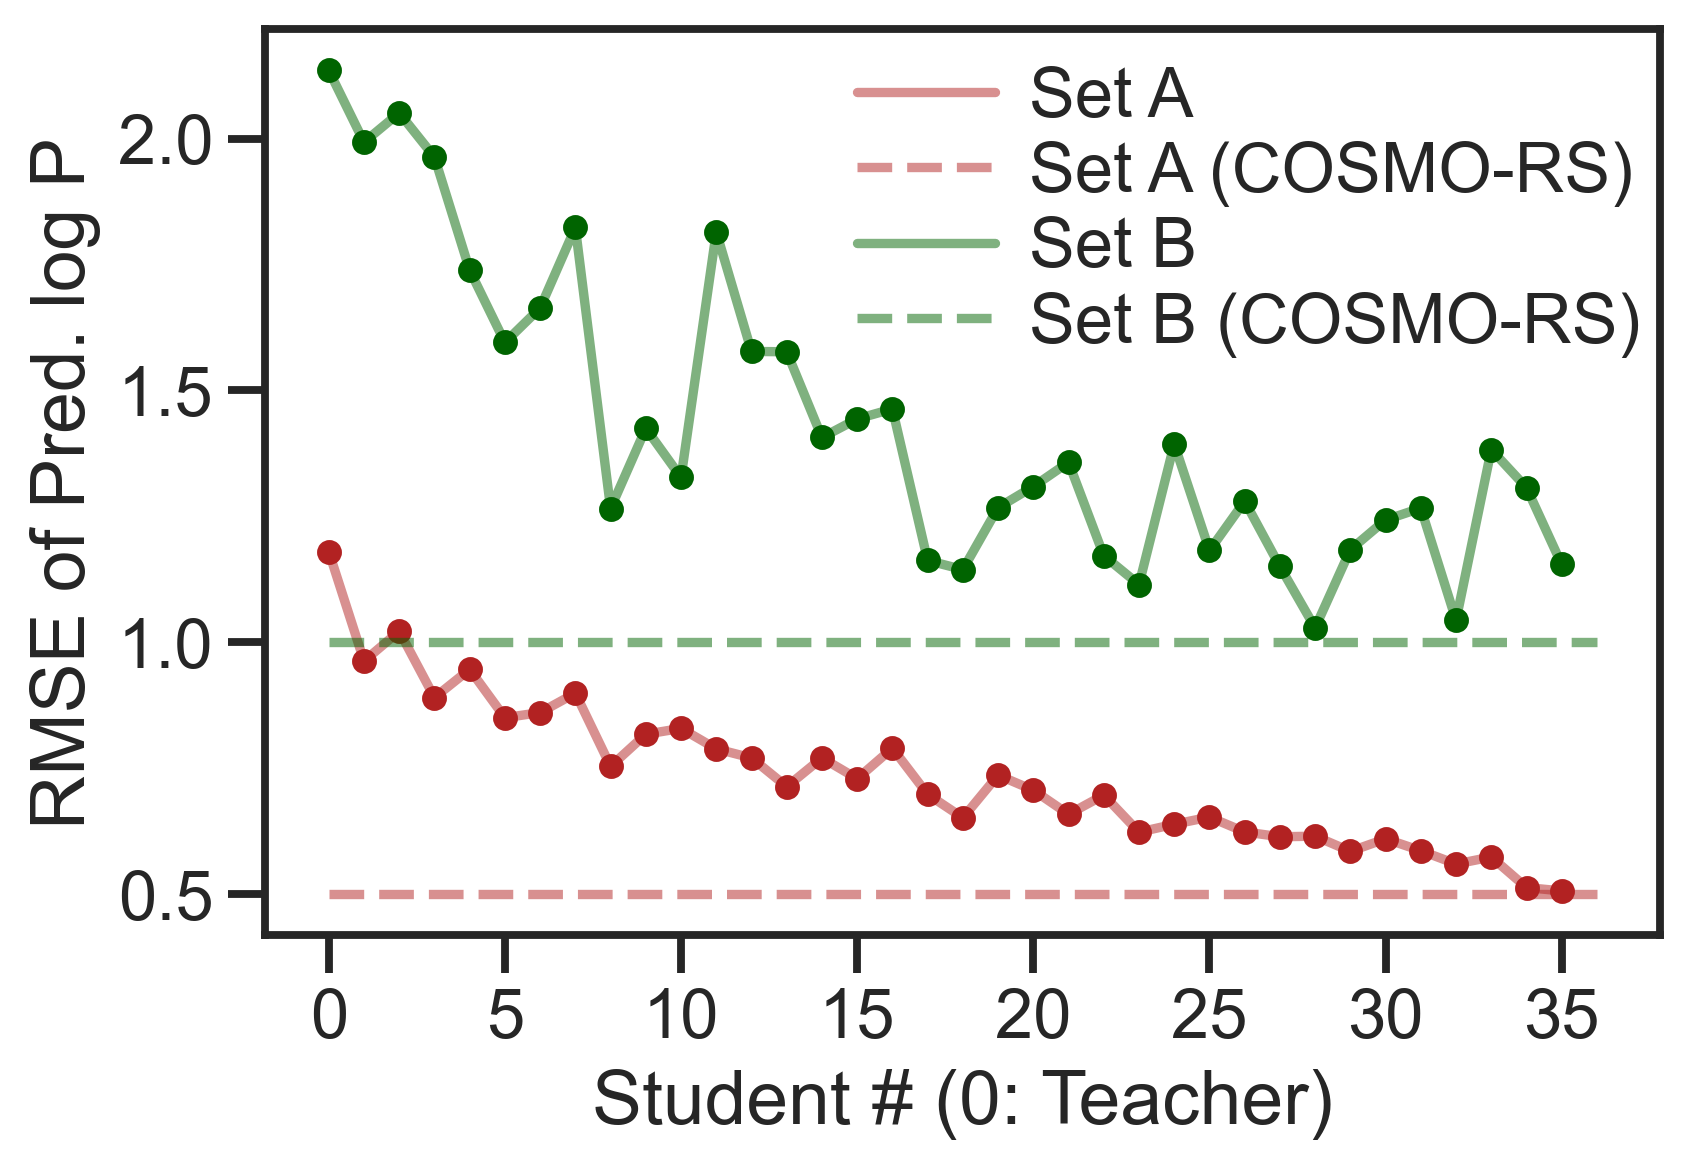

In [4]:
labels = ['Set A', 'Set B', 'Set C']

colors = ['firebrick', 'darkgreen', 'navy']

cosmors_rmse = [0.50, 1.00]

#for i, Y in enumerate([ setA_rmse, setB_rmse, setC_rmse ]):
for i, Y in enumerate([ setA_rmse, setB_rmse]):
    #print(len(Y))
    #plt.plot(range(0,31),Y, alpha = 0.5, label = labels[i])
    #plt.scatter(range(0,31),Y, s=2, alpha = 1.0)
    
    #plt.scatter([0],[Y[0]], s=15, marker='D' ,alpha = 1.0, color = colors[i] )
    
    
    plt.plot(range(0,36),Y[0:36], alpha = 0.5, label = labels[i], color = colors[i])
    plt.scatter(range(0,36),Y[0:36], s=20, alpha = 1.0, color = colors[i])

    #plt.plot(range(1,29),Y[31:], '--', alpha = 0.5, color = colors[i])
    #plt.scatter(range(1,29),Y[31:], s=10, alpha = 1.0, color = colors[i])
    if i <= 1:
       plt.plot([0,36],[cosmors_rmse[i], cosmors_rmse[i]], '--', alpha = 0.5, 
                 color = colors[i], label = labels[i]+' (COSMO-RS)')

plt.xlabel('Student # (0: Teacher)')
plt.ylabel('RMSE of Pred. log P')
plt.xticks([0,5,10,15,20,25,30,35])
plt.legend(handletextpad = 0.5, labelspacing= 0.15,bbox_to_anchor = (.38,.57))

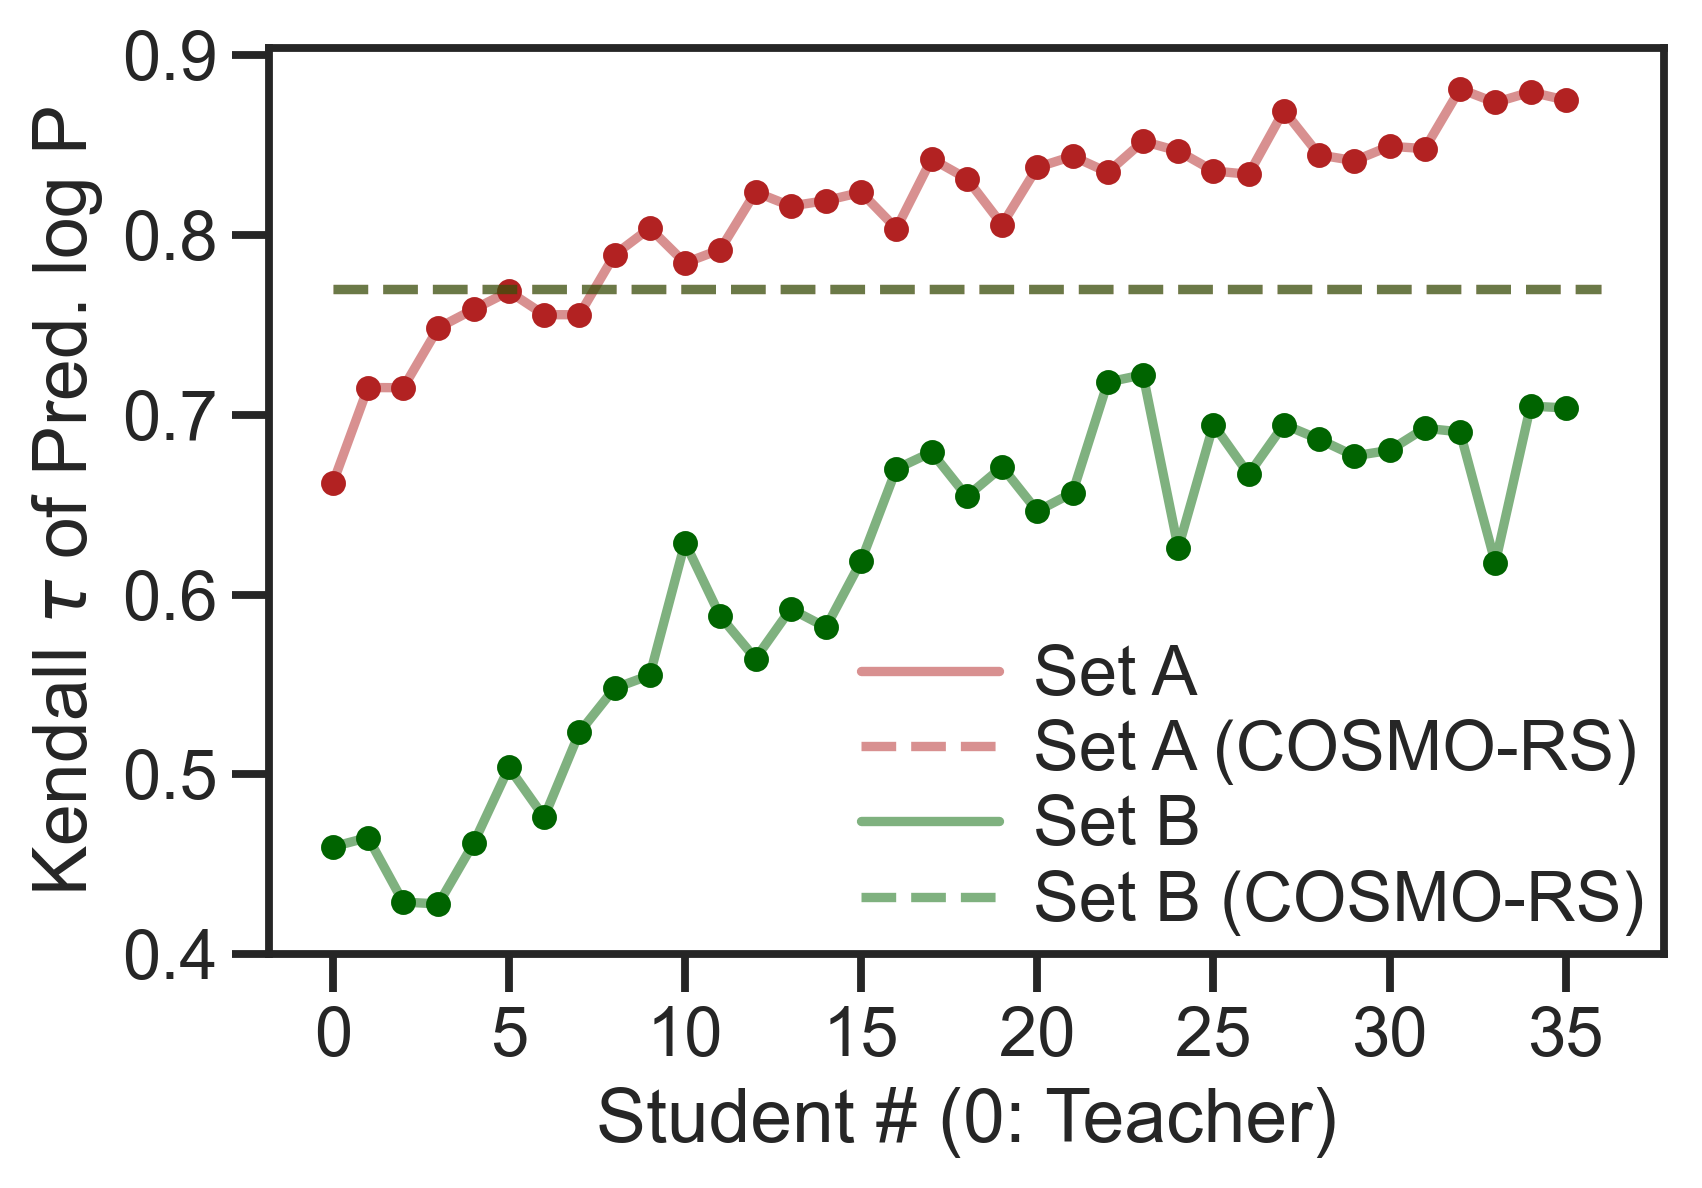

In [5]:
labels = [ 'Set A', 'Set B']

cosmors_tau = [0.77, 0.77]

for i, Y in enumerate([ setA_tau, setB_tau ]):

    #plt.scatter([0],[Y[0]], s=15, marker='D' ,alpha = 1.0, color = colors[i] )
    
    plt.plot(range(0,36),Y[0:36], alpha = 0.5, label = labels[i], color = colors[i])
    plt.scatter(range(0,36),Y[0:36], s=20, alpha = 1.0, color = colors[i])

    #plt.plot(range(1,29),Y[31:], '--', alpha = 0.5, color = colors[i])
    #plt.scatter(range(1,29),Y[31:], s=10, alpha = 1.0, color = colors[i])
    
    if i <= 1:
       plt.plot([0,36],[cosmors_tau[i], cosmors_tau[i]], '--', alpha = 0.5, 
                 color = colors[i], label = labels[i]+' (COSMO-RS)')    

plt.xlabel('Student # (0: Teacher)')
plt.ylabel(r'Kendall $\tau$ of Pred. log P')
plt.xticks([0,5,10,15,20,25,30,35])
plt.yticks([0.4,.5,.6,.7,.8,.9])
plt.legend(handletextpad = 0.5, labelspacing= 0.15, bbox_to_anchor = (.38,.41))
#plt.tight_layout()

prediction_results_student35.csv
0.5062065642119263
1.1544361238248317
KendalltauResult(correlation=0.8749027959154597, pvalue=7.383010377129002e-113)
KendalltauResult(correlation=0.7037420407057614, pvalue=3.8255874013346154e-16)
Set C 1.12525481080645
KendalltauResult(correlation=0.6190476190476191, pvalue=0.06904761904761905)
------------------------


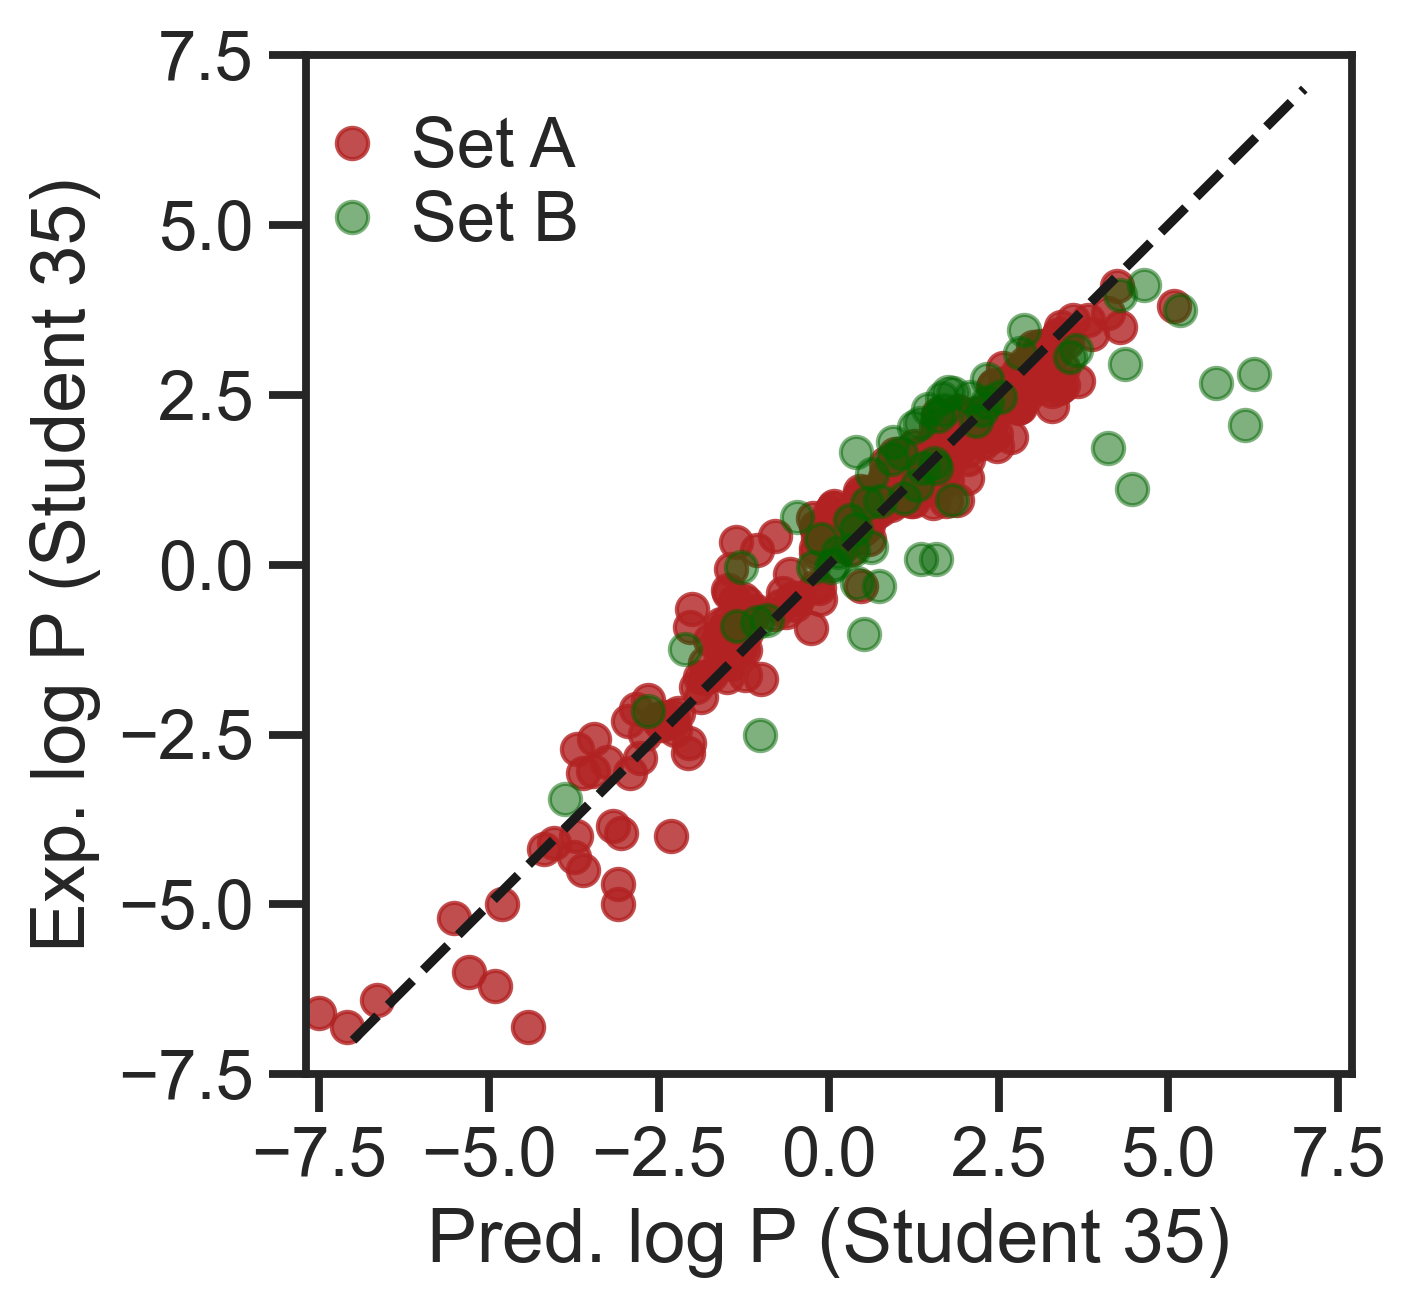

In [6]:
csv_name = 'prediction_results_student35.csv'
logP_exp = pd.read_csv('setA+setB_exp_values.csv')
acidic_basic_pka = {}
acidic_or_basic_solutes = logP_exp[~logP_exp.pKa.isna()]
for solute in acidic_or_basic_solutes.can_smiles_solute.unique():
    pka = acidic_or_basic_solutes[acidic_or_basic_solutes.can_smiles_solute == solute].pKa.iloc[0]
    acidic_basic_pka[solute] = pka    
########################
dgsolv_in_water = {}
df = pd.read_csv(csv_name)
df_setC = df[df.comment.str.contains('setC')]
df = df[df.comment.str.contains('logP')]

for _, row in df[df.can_smiles_solvent == 'O'].iterrows():
    dgsolv_in_water[row['can_smiles_solute']] = row['predicted']
##################
logP_pred = []
for _, row in logP_exp.iterrows():
    solvent, solute = row['can_smiles_solvent'], row['can_smiles_solute']

    DGsolv_org = df[(df['can_smiles_solvent'] == solvent) & (df['can_smiles_solute'] == solute)].iloc[0].predicted
    DGsolv_water = dgsolv_in_water[solute]

    try:
        pred_logP = (DGsolv_water - DGsolv_org) / (2.303 * 1.9872E-3 * 298.15)

        pka = acidic_basic_pka[solute]

        if 'A' in row['solute_name']: # A set contains acidic compounds
            Z = 7 - pka
        else: # B set contains basic compounds 
            Z = pka - 7

        pred_logP = pred_logP - np.log10(1 + (10.0 ** Z) )
    except:
        pred_logP = (DGsolv_water - DGsolv_org) / (2.303 * 1.9872E-3 * 298.15)

    logP_pred.append(pred_logP)

######
setC_results = []
for one_solute, sub_df in df_setC.groupby('can_smiles_solute'):
    exp = setC_exp_logP[one_solute]
    dgsolv_org = sub_df[sub_df.can_smiles_solvent != 'O'].iloc[0].predicted
    dgsolv_water = sub_df[sub_df.can_smiles_solvent == 'O'].iloc[0].predicted
    pred = -(dgsolv_water - dgsolv_org) / (2.303 * 1.9872E-3 * 298.15)
    setC_results.append([exp,pred])
setC_results = pd.DataFrame(np.array(setC_results), columns = ['exp', 'pred'])

######
logP_exp['pred'] = logP_pred
setA_results = logP_exp[logP_exp.comment == 'logP_setA']
setB_results = logP_exp[(logP_exp.comment == 'logP_setB') & (~logP_exp['logP_exp'].isna())]


print(csv_name)
print(np.sqrt(np.mean((setA_results['logP_exp'] - setA_results['pred'])**2)))
print(np.sqrt(np.mean((setB_results['logP_exp'] - setB_results['pred'])**2)))
print(kendalltau(setA_results['logP_exp'], setA_results['pred']))
print(kendalltau(setB_results['logP_exp'], setB_results['pred']))

print('Set C', np.sqrt(np.mean((setC_results['exp'] - setC_results['pred'])**2)))
print(kendalltau(setC_results['exp'], setC_results['pred']))
print('------------------------')
    
    
#######################################
x1, y1, x2, y2, x3, y3 = setA_results['pred'], setA_results['logP_exp'], \
                         setB_results['pred'], setB_results['logP_exp'], \
                         setC_results['pred'], setC_results['exp']

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = 'Arial'
plt.rcParams.update({'font.size': 24})

fig = plt.figure(figsize=(4.5,4.5))
ax = fig.add_subplot(111)
ax.axis('equal')
ax.set_xticks(np.arange(-7.5,7.51,2.5))
ax.set_yticks(np.arange(-7.5,7.51,2.5))
ax.set_xlim([-7.5,7.5])
ax.set_ylim([-7.5,7.5])
ax.set_xlabel('Pred. log P (Student 35)')
ax.set_ylabel('Exp. log P (Student 35)')

from sklearn.metrics import r2_score


#ax.plot(x1, y1, '.', ms=15, label='Set A ($R^2=$'+ '%.2f' % r2_score(x1,y1) +')', alpha=0.5, color='darkgreen')
#ax.plot(x2, y2, '.', ms=15, label='Set B ($R^2=$'+ '%.2f' % r2_score(x2,y2) +')', alpha=0.8, color='firebrick')
ax.plot(x1, y1, '.', ms=15, label='Set A', alpha=0.8, color='firebrick')
ax.plot(x2, y2, '.', ms=15, label='Set B', alpha=0.5, color='darkgreen')
#ax.plot(x3, y3, '.', ms=15, label='Set C ($R^2=$'+ '%.2f' % r2_score(x3,y3) +')', alpha=0.8, color='navy')
#ax.plot(valid_x, valid_y, '.',  ms=15, label='Validation', alpha=0.5, color='darkgreen')
#ax.plot(test_x, test_y, '.',  ms=15, label='Test', alpha=0.5, color='firebrick')
#lgnd = ax.legend(loc='center left', bbox_to_anchor=(-0.08, .75), handletextpad=-0.5)
lgnd = ax.legend(loc='upper left', handletextpad=-0.15, bbox_to_anchor = (-0.08,1.00), labelspacing=0.15)
    
ax.plot([-7,7], [-7, 7], '--', color='.1')

In [7]:
#fig.savefig('SetA+B.png', dpi=300)

In [9]:
setB_results['AE'] = np.abs(setB_results['logP_exp'] - setB_results['pred'])

/Users/kyj/opt/anaconda3/envs/ykim/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
for solute, sub_df in setB_results.groupby('can_smiles_solute'):
    print(solute,sub_df.AE.mean())
    if solute == 'C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C@@H]2O':
        print(solute, sub_df.AE.mean())
        print(sub_df)

CCN(CC)C(=O)c1cccnc1 0.1929721231558394
COC(=O)c1ccccc1C(=O)OC 0.6648613153766988
C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C@@H]2O 0.6097373282777327
C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C@@H]2O 0.6097373282777327
       comment can_smiles_solvent  \
348  logP_setB          Cc1ccccc1   
349  logP_setB              ClCCl   
350  logP_setB       CC(=O)OC(C)C   
351  logP_setB              CCCCO   

                                     can_smiles_solute  logP_exp solute_name  \
348  C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...      2.02         B13   
349  C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...      2.53         B13   
350  C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...      3.16         B13   
351  C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...      3.05         B13   

    Acidic/basic?  pKa      pred        AE  
348             n  NaN  1.259169  0.760831  
349             n  NaN  1.830159  0.699841  
350             n  NaN  3.639883  0.479883  
351    